<a href="https://colab.research.google.com/github/berkyyd/Projects/blob/main/rent_film_uyg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Veri İşleme ve Analiz
import pandas as pd
import numpy as np
from datetime import datetime

# Görselleştirme
import matplotlib.pyplot as plt
import seaborn as sns

# Veri Ön İşleme
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Regresyon Modelleri
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Model Değerlendirme
from sklearn.metrics import mean_squared_error, r2_score

# Çoklu Doğrusal Bağlantı Kontrolü
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Hiperparametre Optimizasyonu
from sklearn.model_selection import GridSearchCV, cross_val_score

In [35]:
def load():
  df = pd.read_csv("rental_info.csv")
  return df

df = load()

In [3]:
df.head()

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401


In [36]:
# bağımlı değişkeni oluşturma
df['rental_date'] = pd.to_datetime(df['rental_date'])
df['return_date'] = pd.to_datetime(df['return_date'])
df['rental_duration'] = (df['return_date'] - df['rental_date']).dt.days
print(df['rental_duration'].describe())

count    15861.000000
mean         4.525944
std          2.635108
min          0.000000
25%          2.000000
50%          5.000000
75%          7.000000
max          9.000000
Name: rental_duration, dtype: float64


Kategorik ve Numerik Değişkenler

In [6]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
  cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
  num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
  cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
  cat_cols = cat_cols + num_but_cat
  cat_cols = [col for col in cat_cols if col not in cat_but_car]

  num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
  num_cols = [col for col in num_cols if col not in num_but_cat]

  print(f"Observations: {dataframe.shape[0]}")
  print(f"Variables: {dataframe.shape[1]}")
  print(f'cat_cols: {len(cat_cols)}')
  print(f'num_cols: {len(num_cols)}')
  print(f'cat_but_car: {len(cat_but_car)}')
  print(f'num_but_cat: {len(num_but_cat)}')
  return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)
cat_cols, num_cols

Observations: 15861
Variables: 16
cat_cols: 8
num_cols: 8
cat_but_car: 0
num_but_cat: 7


(['special_features',
  'release_year',
  'rental_rate',
  'NC-17',
  'PG',
  'PG-13',
  'R',
  'rental_rate_2'],
 ['rental_date',
  'return_date',
  'amount',
  'length',
  'replacement_cost',
  'amount_2',
  'length_2',
  'rental_duration'])

Aykırı Değerler

In [7]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquartile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquartile_range
    low_limit = quartile1 - 1.5 * interquartile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
  low_limit, up_limit = outlier_thresholds(dataframe, col_name)
  if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
    return True
  else:
    return False

check_outlier(df, num_cols)

<ipython-input-7-621c2ca3da5e>:11: FutureWarning: 'any' with datetime64 dtypes is deprecated and will raise in a future version. Use (obj != pd.Timestamp(0)).any() instead.
  if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):


False

Eksik Değerler

In [8]:
def missing_values_table(dataframe, na_name=False):
  na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum()>0]
  n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
  ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
  missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
  print(missing_df, end="\n")
  if na_name:
    return na_columns

missing_values_table(df)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
amount,15861.0,4.217161,2.360383,0.9900,2.9900,3.9900,4.9900,11.9900
release_year,15861.0,2006.885379,2.025027,2004.0000,2005.0000,2007.0000,2009.0000,2010.0000
rental_rate,15861.0,2.944101,1.649766,0.9900,0.9900,2.9900,4.9900,4.9900
length,15861.0,114.994578,40.114715,46.0000,81.0000,114.0000,148.0000,185.0000
replacement_cost,15861.0,20.224727,6.083784,9.9900,14.9900,20.9900,25.9900,29.9900
NC-17,15861.0,0.204842,0.403599,0.0000,0.0000,0.0000,0.0000,1.0000
PG,15861.0,0.200303,0.400239,0.0000,0.0000,0.0000,0.0000,1.0000
PG-13,15861.0,0.223378,0.416523,0.0000,0.0000,0.0000,0.0000,1.0000
R,15861.0,0.198726,0.399054,0.0000,0.0000,0.0000,0.0000,1.0000
amount_2,15861.0,23.355504,23.503164,0.9801,8.9401,15.9201,24.9001,143.7601


Korelasyon Analizi

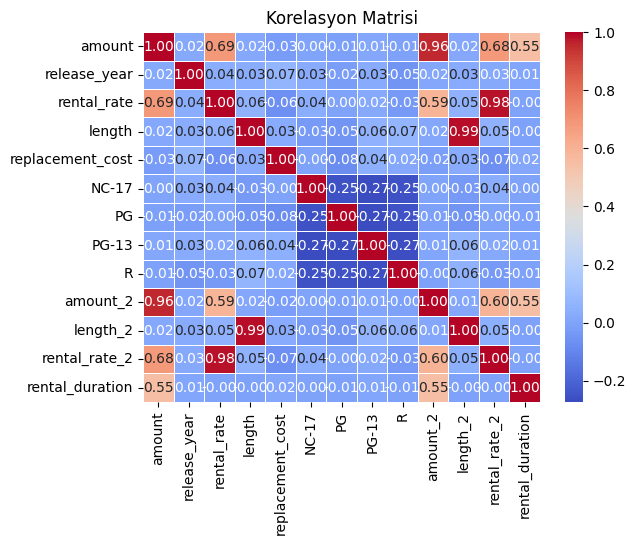

In [37]:
# Sayısal değişkenleri seçme (kategori içermeyen sütunları filtreleyerek)
numeric_df = df.select_dtypes(include=["number"])

# Korelasyon matrisini hesaplama
correlation_matrix = numeric_df.corr()

# Korelasyonları görselleştirme
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Korelasyon Matrisi")
plt.show()


In [ ]:
# rental_rate ve amount gibi değişkenlerin korelasyonu çok yüksek çıktı.
# bunlara bağlı olarak kareleri olan değişkenlerde haliyle yüksek çıktı.
# bunları şimdi vif testine sokucaz

In [38]:
# VIF hesaplama fonksiyonu
def calculate_vif(data):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = data.columns
    vif_data["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_data

# rental_duration bağımlı değişken olduğu için hariç tutarak sayısal değişkenleri seçme
numeric_features = df.select_dtypes(include=["number"]).columns.tolist()
numeric_features.remove("rental_duration")  # Bağımlı değişkeni çıkar

# VIF hesaplama
vif_df = calculate_vif(df[numeric_features])
print(vif_df)


             Feature         VIF
0             amount   71.862931
1       release_year  104.489977
2        rental_rate  139.907287
3             length  378.863023
4   replacement_cost   12.212287
5              NC-17    2.195328
6                 PG    2.173316
7              PG-13    2.307946
8                  R    2.171650
9           amount_2   27.976684
10          length_2  143.439389
11     rental_rate_2   71.847536


In [39]:
# burda da çok yüksek değerler aldığını gördük bizim için 10-20 üstü değerler çok o yüzden aynısının karesi olan değişkenleri çıkarıyoruz

# Yüksek VIF değerine sahip değişkenleri çıkarma
high_vif_features = ["length_2", "rental_rate_2", "amount_2"]
df = df.drop(columns=high_vif_features)

# Güncellenmiş VIF hesaplama
numeric_features = df.select_dtypes(include=["number"]).columns.tolist()
numeric_features.remove("rental_duration")  # Bağımlı değişkeni çıkar

vif_df = calculate_vif(df[numeric_features])
print(vif_df)


            Feature        VIF
0            amount   7.941378
1      release_year  28.347674
2       rental_rate   8.000897
3            length   9.366210
4  replacement_cost  12.206071
5             NC-17   2.192775
6                PG   2.168495
7             PG-13   2.307117
8                 R   2.162635


In [ ]:
# şimdi gayet iyi durumda bunlar bizim için yeterli

Yeni Özellik Eklenmesi

In [40]:
# hafta içi ve hafta sonu gibi değişkenler ekleyelim

# Haftanın günü (0: Pazartesi, 6: Pazar) bilgisi ekleyelim
df['rental_weekday'] = df['rental_date'].dt.weekday
df['return_weekday'] = df['return_date'].dt.weekday

# Hafta içi (0-4) ve hafta sonu (5-6) kategorisini ekleyelim
df['rental_is_weekend'] = df['rental_weekday'].apply(lambda x: 1 if x >= 5 else 0)
df['return_is_weekend'] = df['return_weekday'].apply(lambda x: 1 if x >= 5 else 0)

In [17]:
df.head()

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,rental_duration,rental_weekday,return_weekday,rental_is_weekend,return_is_weekend
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,3,2,5,0,1
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,2,2,5,0,1
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,7,6,6,1,1
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,2,6,1,1,0
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,4,4,1,0,0


Encoding Dönüşümleri

In [41]:
# rental_date ve return_date'i epoch zamanına göre gün olarak dönüştürelim
df['rental_date_days'] = (df['rental_date'].dt.tz_localize(None) - pd.Timestamp('1970-01-01')).dt.days
df['return_date_days'] = (df['return_date'].dt.tz_localize(None) - pd.Timestamp('1970-01-01')).dt.days

# Kontrol et
print(df[['rental_date', 'return_date', 'rental_date_days', 'return_date_days']].head())

                rental_date               return_date  rental_date_days  \
0 2005-05-25 02:54:33+00:00 2005-05-28 23:40:33+00:00             12928   
1 2005-06-15 23:19:16+00:00 2005-06-18 19:24:16+00:00             12949   
2 2005-07-10 04:27:45+00:00 2005-07-17 10:11:45+00:00             12974   
3 2005-07-31 12:06:41+00:00 2005-08-02 14:30:41+00:00             12995   
4 2005-08-19 12:30:04+00:00 2005-08-23 13:35:04+00:00             13014   

   return_date_days  
0             12931  
1             12952  
2             12981  
3             12997  
4             13018  


In [42]:
# Süslü parantezleri ve çift tırnakları kaldır
df['special_features_cleaned'] = df['special_features'].str.replace(r'[{}"]', '', regex=True)

# Virgül ile ayırıp One-Hot Encoding yapalım
df_special_features = df['special_features_cleaned'].str.get_dummies(sep=',').astype(int)

# Orijinal veriyle birleştirelim
df = pd.concat([df, df_special_features], axis=1)

# Kontrol edelim
df.head()

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,...,return_weekday,rental_is_weekend,return_is_weekend,rental_date_days,return_date_days,special_features_cleaned,Behind the Scenes,Commentaries,Deleted Scenes,Trailers
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,...,5,0,1,12928,12931,"Trailers,Behind the Scenes",1,0,0,1
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,...,5,0,1,12949,12952,"Trailers,Behind the Scenes",1,0,0,1
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,...,6,1,1,12974,12981,"Trailers,Behind the Scenes",1,0,0,1
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,...,1,1,0,12995,12997,"Trailers,Behind the Scenes",1,0,0,1
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,...,1,0,0,13014,13018,"Trailers,Behind the Scenes",1,0,0,1


In [43]:
# Gereksiz sütunları silelim
df = df.drop(['special_features', 'special_features_cleaned', 'rental_date', 'return_date'], axis=1)

# Kontrol edelim
df.head()

,amount,release_year,rental_rate,length,replacement_cost,NC-17,PG,PG-13,R,rental_duration,rental_weekday,return_weekday,rental_is_weekend,return_is_weekend,rental_date_days,return_date_days,Behind the Scenes,Commentaries,Deleted Scenes,Trailers
0,2.99,2005.0,2.99,126.0,16.99,0,0,0,1,3,2,5,0,1,12928,12931,1,0,0,1
1,2.99,2005.0,2.99,126.0,16.99,0,0,0,1,2,2,5,0,1,12949,12952,1,0,0,1
2,2.99,2005.0,2.99,126.0,16.99,0,0,0,1,7,6,6,1,1,12974,12981,1,0,0,1
3,2.99,2005.0,2.99,126.0,16.99,0,0,0,1,2,6,1,1,0,12995,12997,1,0,0,1
4,2.99,2005.0,2.99,126.0,16.99,0,0,0,1,4,4,1,0,0,13014,13018,1,0,0,1


Standartlaştırma

In [46]:
from sklearn.preprocessing import StandardScaler

# StandardScaler ile tüm sayısal sütunları standartlaştıralım
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# Standartlaştırılmış veriyi DataFrame'e çevirelim
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

# Kontrol edelim
df_scaled.head()

,amount,release_year,rental_rate,length,replacement_cost,NC-17,PG,PG-13,R,rental_duration,rental_weekday,return_weekday,rental_is_weekend,return_is_weekend,rental_date_days,return_date_days,Behind the Scenes,Commentaries,Deleted Scenes,Trailers
0,-0.519915,-0.931069,0.027822,0.274357,-0.531713,-0.507555,-0.500473,-0.536309,2.007995,-0.579100,-0.509915,0.987011,-0.643048,1.566781,-2.174095,-2.238899,0.929766,-1.090382,-0.994655,0.940545
1,-0.519915,-0.931069,0.027822,0.274357,-0.531713,-0.507555,-0.500473,-0.536309,2.007995,-0.958604,-0.509915,0.987011,-0.643048,1.566781,-1.367995,-1.437469,0.929766,-1.090382,-0.994655,0.940545
2,-0.519915,-0.931069,0.027822,0.274357,-0.531713,-0.507555,-0.500473,-0.536309,2.007995,0.938912,1.482266,1.485577,1.555095,1.566781,-0.408351,-0.330732,0.929766,-1.090382,-0.994655,0.940545
3,-0.519915,-0.931069,0.027822,0.274357,-0.531713,-0.507555,-0.500473,-0.536309,2.007995,-0.958604,1.482266,-1.007254,1.555095,-0.638251,0.397749,0.279881,0.929766,-1.090382,-0.994655,0.940545
4,-0.519915,-0.931069,0.027822,0.274357,-0.531713,-0.507555,-0.500473,-0.536309,2.007995,-0.199597,0.486176,-1.007254,-0.643048,-0.638251,1.127078,1.081312,0.929766,-1.090382,-0.994655,0.940545


Model

In [47]:
# Gerekli kütüphaneler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [48]:
# Veriyi X ve y olarak ayıralım (y = bağımlı değişken, X = bağımsız değişkenler)
X = df.drop('rental_duration', axis=1)  # bağımlı değişkeni çıkartıyoruz
y = df['rental_duration']  # hedef değişken

# Veriyi eğitim ve test olarak bölelim
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Model değerlendirme fonksiyonu
def evaluate_models(X_train, X_test, y_train, y_test):
    models = {
        "Linear Regression": LinearRegression(),
        "Lasso Regression": Lasso(),
        "Ridge Regression": Ridge(),
        "Decision Tree": DecisionTreeRegressor(),
        "Random Forest": RandomForestRegressor(),
        "Gradient Boosting": GradientBoostingRegressor()
    }

    results = {}

    for model_name, model in models.items():
        # Modeli eğit
        model.fit(X_train, y_train)

        # Tahmin yap
        y_pred = model.predict(X_test)

        # MSE, RMSE ve R² hesapla
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)

        # Sonuçları sakla
        results[model_name] = {
            "MSE": mse,
            "RMSE": rmse,
            "R²": r2
        }

    # Sonuçları DataFrame formatında döndür
    return pd.DataFrame(results)

# Modelleri değerlendir
results_df = evaluate_models(X_train, X_test, y_train, y_test)

# Sonuçları yazdır
results_df

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.862e+01, tolerance: 8.833e+00
  model = cd_fast.enet_coordinate_descent(


,Linear Regression,Lasso Regression,Ridge Regression,Decision Tree,Random Forest,Gradient Boosting
MSE,0.249679,0.832661,0.249680,0.869839,0.517373,1.206463
RMSE,0.499679,0.912503,0.499680,0.932652,0.719286,1.098391
R²,0.963654,0.878787,0.963653,0.873375,0.924685,0.824372


Hiperparametre Optimizasyonu

In [50]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer

# Hyperparameter tuning ve Cross-Validation için fonksiyon
def optimize_and_evaluate_models(X_train, X_test, y_train, y_test):
    models = {
        "Linear Regression": LinearRegression(),
        "Lasso Regression": Lasso(),
        "Ridge Regression": Ridge(),
        "Decision Tree": DecisionTreeRegressor(),
        "Random Forest": RandomForestRegressor(),
        "Gradient Boosting": GradientBoostingRegressor()
    }

    # Hiperparametreler için parametre ızgaraları
    param_grids = {
        "Lasso Regression": {"alpha": [0.1, 1, 10, 100]},
        "Ridge Regression": {"alpha": [0.1, 1, 10, 100]},
        "Decision Tree": {"max_depth": [None, 10, 20, 30], "min_samples_split": [2, 5, 10]},
        "Random Forest": {"n_estimators": [100, 200], "max_depth": [None, 10, 20], "min_samples_split": [2, 5]},
        "Gradient Boosting": {"n_estimators": [100, 200], "learning_rate": [0.01, 0.1, 0.2], "max_depth": [3, 5, 7]}
    }

    results = {}

    for model_name, model in models.items():
        print(f"Optimizing {model_name}...")

        # Eğer model için parametre ızgarası varsa, GridSearchCV kullan
        if model_name in param_grids:
            grid_search = GridSearchCV(model, param_grids[model_name], cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_
            best_params = grid_search.best_params_
            print(f"Best parameters for {model_name}: {best_params}")
        else:
            best_model = model
            best_model.fit(X_train, y_train)

        # Modeli test verisi üzerinde değerlendirme
        y_pred = best_model.predict(X_test)

        # MSE, RMSE ve R² hesapla
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)

        # Cross-validation ile modelin genelleme yeteneğini değerlendir
        cross_val_score_mean = np.mean(cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))

        # Sonuçları sakla
        results[model_name] = {
            "Best Params": best_params if model_name in param_grids else "N/A",
            "MSE": mse,
            "RMSE": rmse,
            "R²": r2,
            "Cross-Validation Mean Score (MSE)": cross_val_score_mean
        }

    # Sonuçları DataFrame formatında döndür
    return pd.DataFrame(results)

# Modelleri optimize et ve değerlendirme
optimized_results_df = optimize_and_evaluate_models(X_train, X_test, y_train, y_test)

# Sonuçları yazdır
optimized_results_df

Optimizing Linear Regression...
Optimizing Lasso Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.131e+02, tolerance: 8.833e+00
  model = cd_fast.enet_coordinate_descent(


Best parameters for Lasso Regression: {'alpha': 0.1}


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.760e+02, tolerance: 7.034e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.771e+02, tolerance: 7.062e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.670e+02, tolerance: 7.092e

Optimizing Ridge Regression...
Best parameters for Ridge Regression: {'alpha': 10}
Optimizing Decision Tree...
Best parameters for Decision Tree: {'max_depth': 30, 'min_samples_split': 10}
Optimizing Random Forest...
Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Optimizing Gradient Boosting...
Best parameters for Gradient Boosting: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}


,Linear Regression,Lasso Regression,Ridge Regression,Decision Tree,Random Forest,Gradient Boosting
Best Params,N/A,{'alpha': 0.1},{'alpha': 10},"{'max_depth': 30, 'min_samples_split': 10}","{'max_depth': None, 'min_samples_split': 2, 'n...","{'learning_rate': 0.2, 'max_depth': 5, 'n_esti..."
MSE,0.249679,0.255289,0.249689,0.771785,0.51877,0.312925
RMSE,0.499679,0.505262,0.499689,0.878513,0.720257,0.559397
R²,0.963654,0.962837,0.963652,0.887649,0.924481,0.954447
Cross-Validation Mean Score (MSE),-0.24749,-0.256069,-0.247488,-0.909487,-0.560205,-0.31996


Feature Importances

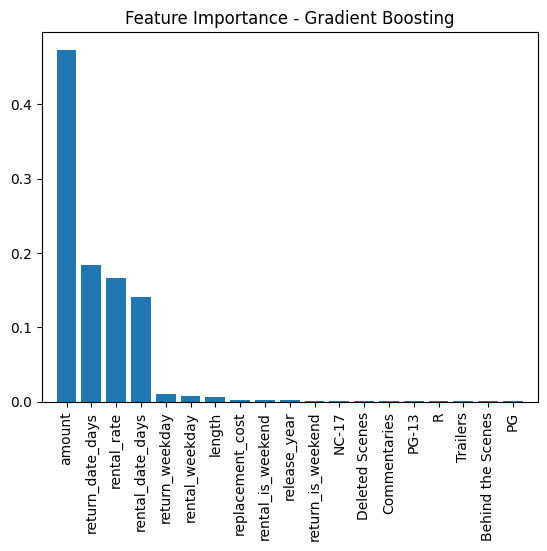

In [58]:
# Gradient Boosting modelini en iyi parametrelerle yeniden eğit
best_params = {
    'learning_rate': 0.2,
    'max_depth': 5,
    'n_estimators': 200
}

# Modeli oluştur ve eğit
gb_model = GradientBoostingRegressor(**best_params)
gb_model.fit(X_train, y_train)

# Feature importances
importances = gb_model.feature_importances_

# Özelliklerin önemini görselleştirmek için
indices = np.argsort(importances)[::-1]  # Azalan sıraya göre sıralama

plt.title("Feature Importance - Gradient Boosting")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()


In [ ]:
# 1-> Amount : Kiralama ücreti ürünün kiralanma başarısının belirleyicisidir. Doğru fiyatlandırma kritik öneme sahiptir.
# 2-> Return date days : Kiralanan filmlerin geri dönüş süreleri önemlidir. Şirket buna göre envanter planlamasını optimize edebilir.
# 3-> Rental rate : Filmin talebini gösterir. Yüksek talep varsa buraya doğru odaklanmak başarıyı getirebilir.
# 4-> Rental date days : Kiralama tarihleri talebin arttığı dönemi işaret eder. Buna göre kiralama için doğru zaman seçilebilir.

Çıkarımlar

In [ ]:
# Fiyatlandırma Stratejileri -> Kiralama ücreti ve oranları doğru belirlenmeli çünkü bunlar ürünün talebine doğrudan etki eden en yüksek değişkenler.
# Fiyat optimizasyonu geliri arttırabilir.

# Envanter Yönetimi -> Ürünlerin geri dönüş zamanları doğru tahmin edilerek envanter daha iyi yönetilebilir. Eksik veya fazla stok durumu kontrol altına alınır.

# Kiralama Süresi ve Zamanlama -> Kiralama süreleri ve geri dönüş tarihleri doğru zamanlamayla daha fazla kiralama olanağı sağlayabilir. Bu veriler
# talebin arttığı zamanda daha fazla ürün sunmak için kullanılabilir.

# Talep -> Yüksek kiralama oranları bu ürünlerde yüksek talebin olduğuna işaret eder. Bunlara daha fazla odaklanılırsa iyi gelir elde edilebilir.